In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn import preprocessing

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import BatchNormalization, LeakyReLU
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.callbacks.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt

import time

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from itertools import cycle
from sklearn import metrics

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
dataset1 = pd.read_csv('/content/drive/My Drive/255 Project/final_dataset.csv')
X=[]
y=[]
X = dataset1.iloc[:,:-2].to_numpy()
y = dataset1.iloc[:,-2].to_numpy()

In [0]:
dataset1.shape

(536764, 44)

In [0]:
def plot_roc(y_pred_val, y_testlb_val, y_predlb_val, classifier,count):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(np.unique(y_pred_val))):
    fpr[i], tpr[i], _ = roc_curve(y_testlb_val[:, i], y_predlb_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  n_classes = len(np.unique(y_pred_val))
  print('n_classes',n_classes)
  print('fpr[i] ',fpr[i])
  print('tpr[i] ',tpr[i])
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    # Plot all ROC curves
  plt.figure()
  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
               label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristics '+classifier)
  plt.legend(loc="lower right")
  plt.savefig('ROC '+classifier+' '+str(count)+'.png')
  plt.show()
  plt.clf()

In [0]:
model = Sequential()
model.add(Dense(256, input_shape=(42,)))
model.add(BatchNormalization(momentum=0.8))
model.add(LeakyReLU(0.2))
model.add(Dropout(.4))
model.add(Dense(128))
model.add(BatchNormalization(momentum=0.8))
model.add(LeakyReLU(0.2))
model.add(Dropout(.4))
model.add(Dense(64))
model.add(BatchNormalization(momentum=0.8))
model.add(LeakyReLU(0.2))
model.add(Dropout(.4))
model.add(Dense(16))
model.add(BatchNormalization(momentum=0.8))
model.add(LeakyReLU(0.2))
model.add(Dropout(.4))
model.add(Dense(10, activation='softmax'))

In [0]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               11008     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 128)              

In [0]:
skf = StratifiedKFold(n_splits=5,shuffle = True)

time_cnn = []

cv_score1 = []
cv_score2 = []
all_history = []
y_pred_all = []
roc_cnn = []
y_test_all = []

for train_index, test_index in skf.split(X, y):
     count = 0
     print("TRAIN:", train_index, "TEST:", test_index)

     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]

     s = time.clock()

     es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, 
                        restore_best_weights = True, verbose = 1)
     rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 5, 
                               factor = 0.2, min_lr = 1e-6, verbose = 1)

     history = model.fit(X_train, y_train, epochs=50, batch_size=512,
               validation_split=0.2, verbose=1,
               callbacks = [es, rlrop],
               shuffle=True) 
     score1 = model.evaluate(X_test, y_test)
     print('SCORE1:\n', score1)
     y_pred = model.predict(X_test)

     e = time.clock() - s
     time_cnn.append(e)
     print("Time taken by CNN model: ", e,"seconds \n")
     cv_score1.append(score1)
     all_history.append(history)
     y_pred_all.append(y_pred)
     y_test_all.append(y_test)

    #  lb = preprocessing.LabelBinarizer()
    #  y_testlb = lb.fit_transform(y_test)
    #  y_predlb = lb.fit_transform(y_pred)
    #  plot_roc(y_pred, y_testlb, y_predlb, "CNN",count)
    #  count+=1
     
    #  roc_score = roc_auc_score(y_testlb,y_predlb)
    #  print('ROC SCORE:\n',roc_score,'\n') 
    #  roc_cnn.append(roc_score)


print("Time taken by CNN model: ", (sum(time_cnn)/5),"seconds \n")

TRAIN: [     0      2      3 ... 536761 536762 536763] TEST: [     1      7     16 ... 536748 536749 536754]
Train on 343528 samples, validate on 85883 samples
Epoch 1/50
343528/343528 [==============================] - 13s 38us/step - loss: 1.3530 - accuracy: 0.4010 - val_loss: 1.3486 - val_accuracy: 0.4020
Epoch 2/50
343528/343528 [==============================] - 13s 38us/step - loss: 1.3532 - accuracy: 0.4019 - val_loss: 1.3486 - val_accuracy: 0.4020
Epoch 3/50
343528/343528 [==============================] - 13s 39us/step - loss: 1.3528 - accuracy: 0.4016 - val_loss: 1.3484 - val_accuracy: 0.4020
Epoch 4/50
343528/343528 [==============================] - 13s 39us/step - loss: 1.3528 - accuracy: 0.4041 - val_loss: 1.3478 - val_accuracy: 0.4020
Epoch 5/50
343528/343528 [==============================] - 13s 39us/step - loss: 1.3529 - accuracy: 0.4066 - val_loss: 1.3479 - val_accuracy: 0.4020
Epoch 6/50
343528/343528 [==============================] - 13s 38us/step - loss: 1.3528 -

In [0]:
time_cnn

[1034.7309690000002,
 682.584292,
 238.58754,
 1025.1441930000005,
 492.6858710000006]

In [0]:
print('cv_score1\n',cv_score1)


cv_score1
 [[1.3033146057508855, 0.7579107880592346], [1.2219142738579494, 0.7846636772155762], [1.2113397498224654, 0.7868713736534119], [1.0925271838947013, 0.7916965484619141], [1.022494799507669, 0.7935669422149658]]


In [0]:
y_pred_class = []
for i in range(5):
  temp = []
  for j in range(len(y_pred_all[i])):
    #temp.append(list(y_pred_all[i]).index(max(y_pred_all[i][j])).any())
    temp.append(y_pred_all[i][j].argmax(axis=0))
  y_pred_class.append(temp)


In [0]:
f1_cnn = []
for i in range(5):
  score = f1_score(y_test_all[i], y_pred_class[i], average='micro')
  f1_cnn.append(score)
print(f1_cnn)
f1_cnn_avg = np.mean(f1_cnn)
print("Avg F1 score",f1_cnn_avg,'\n')

[0.7579108175831136, 0.7846636796363399, 0.7868713496595345, 0.7916965524950397, 0.7935669572993517]
Avg F1 score 0.7829418713346759 



In [0]:
for i in range(5):
  print("Run ", i)
  print(confusion_matrix(y_test_all[i], y_pred_class[i]))

Run  0
[[39382     0     0     0  3715     0     0     0     0     0]
 [ 7005     0     0     0  1900     0     0     0     0     0]
 [ 2063     0     0     0   734     0     0     0     0     0]
 [ 1768     0     0     0  1503     0     0     0     0     0]
 [ 1114     0     0     0 41982     0     0     0     0     0]
 [  199     0     0     0   103     0     0     0     0     0]
 [ 3464     0     0     0  1385     0     0     0     0     0]
 [   29     0     0     0     6     0     0     0     0     0]
 [  254     0     0     0   211     0     0     0     0     0]
 [  303     0     0     0   233     0     0     0     0     0]]
Run  1
[[42433     0     0     0   663     0     0     0     0     0]
 [ 7994     0     0     0   911     0     0     0     0     0]
 [ 2551     0     0     0   247     0     0     0     0     0]
 [ 2518     0     0     0   752     0     0     0     0     0]
 [ 1294     0     0     0 41803     0     0     0     0     0]
 [  240     0     0     0    62     0   

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


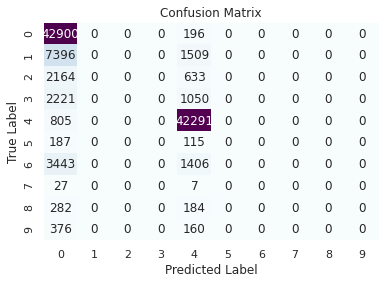

In [0]:
import seaborn as sn
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    sn.set(font_scale=1.0)
    sn.heatmap(cm, cmap="BuPu", annot=True,cbar=False,fmt='d')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.savefig('confusion.png')


cmatrix = confusion_matrix(y_test_all[4], y_pred_class[4], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) #5th iter has best Confusion Matrix
cm = pd.DataFrame(cmatrix, range(10), range(10))
plot_confusion_matrix(cm, ['Normal', 'Exploits', 'Reconnaissance', 'DoS', 'Generic', 'Shellcode', 'Fuzzers', 'Worms', 'Backdoors', 'Analysis'], normalize=False)

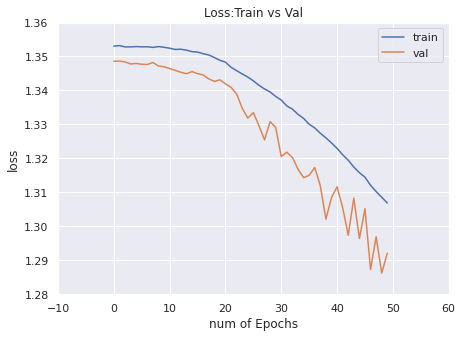

<Figure size 640x480 with 0 Axes>

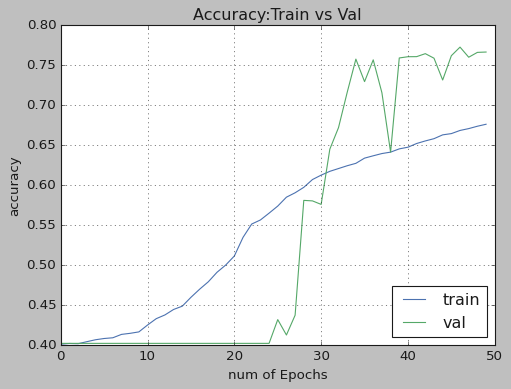

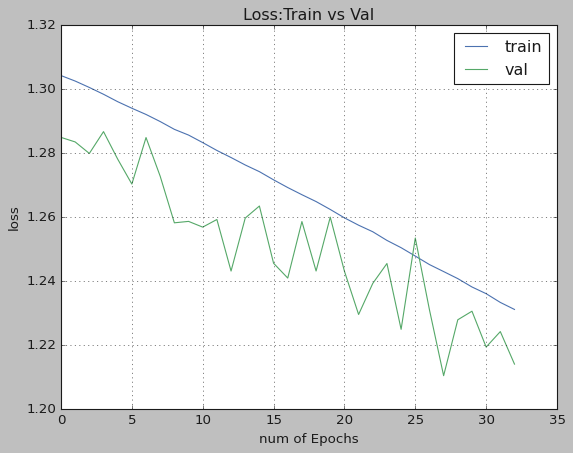

<Figure size 640x480 with 0 Axes>

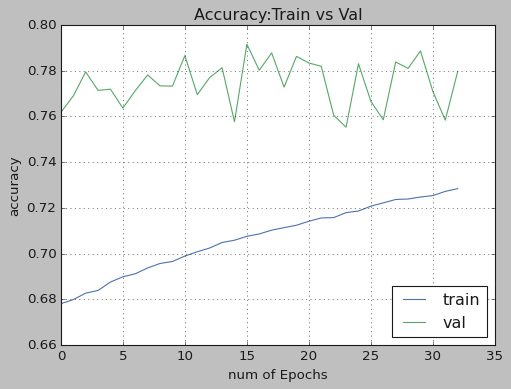

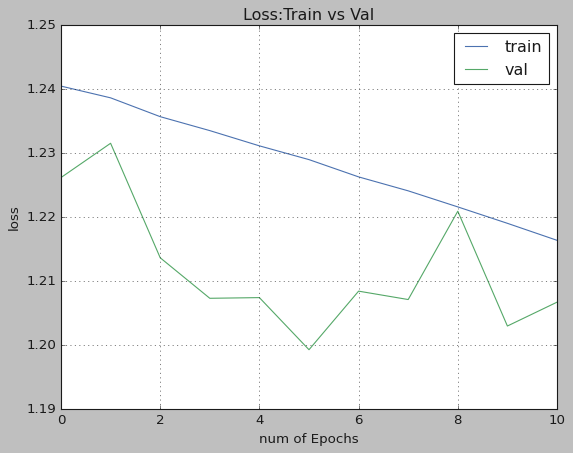

<Figure size 640x480 with 0 Axes>

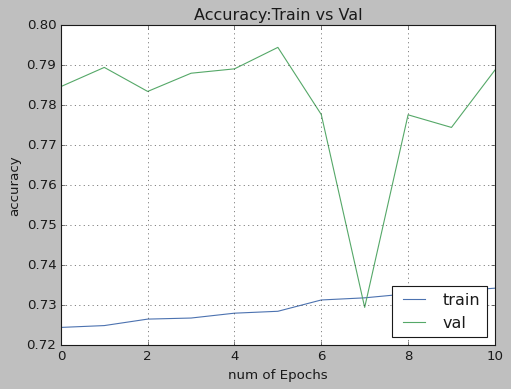

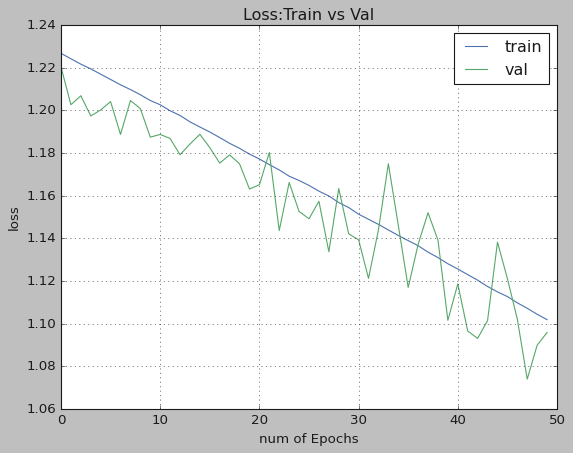

<Figure size 640x480 with 0 Axes>

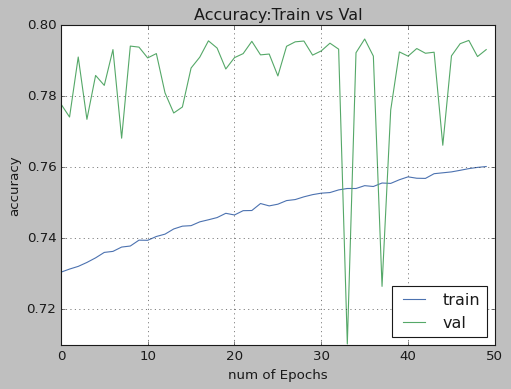

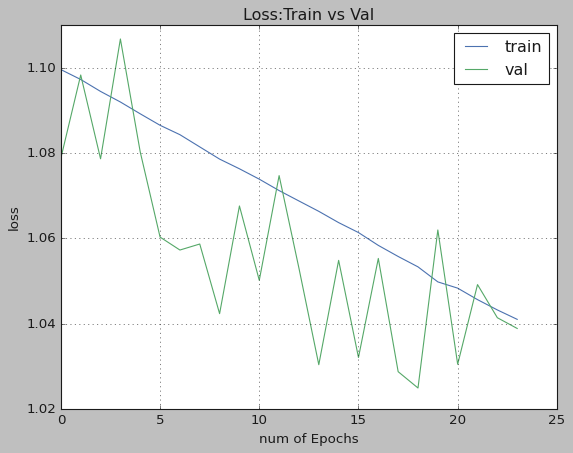

<Figure size 640x480 with 0 Axes>

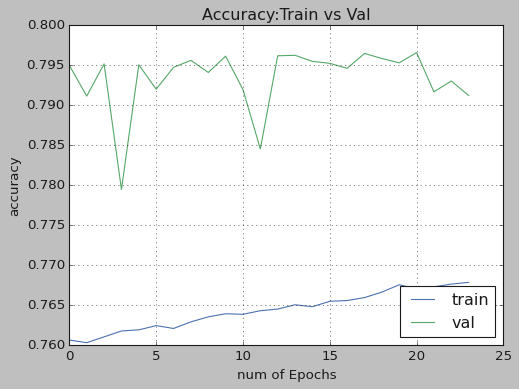

<Figure size 640x480 with 0 Axes>

In [0]:
i=1
for hist in all_history:
  train_loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  train_acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  xc = range(len(train_loss))
  plt.figure(1, figsize=(7, 5))
  plt.plot(xc, train_loss)
  plt.plot(xc, val_loss)
  plt.xlabel('num of Epochs')
  plt.ylabel('loss')
  plt.title('Loss:Train vs Val')
  plt.grid(True)
  plt.legend(['train', 'val'])
  plt.style.use(['classic'])
  plt.savefig('Loss_Plot'+str(i)+'.png')
  plt.show()
  plt.clf()

  plt.figure(2, figsize=(7, 5))
  plt.plot(xc, train_acc)
  plt.plot(xc, val_acc)
  plt.xlabel('num of Epochs')
  plt.ylabel('accuracy')
  plt.title('Accuracy:Train vs Val')
  plt.grid(True)
  plt.legend(['train', 'val'], loc=4)
  plt.style.use(['classic'])
  plt.savefig('Accuracy_Plot'+str(i)+'.png')
  plt.show()
  plt.clf()
  i+=1